<a href="https://colab.research.google.com/github/alexmjn/NBA-Injuries/blob/master/NBA_Injuries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Injuries and Rest in the NBA

>In 2017-18, the number of NBA games lost to injury or illness surpassed the 5,000 mark for the first time since the league stopped using the injured reserve list prior to the 2005-06 campaign, per certified athletic trainer Jeff Stotts.

>Silver, in an interview with ESPN, calls the issue "the highest priority for the league -- and I think both in terms of the health and wellness of the players in the NBA, but also the larger category of millions of players, boys and girls, not just in the United States, but globally."

([ESPN][1])

[1]:https://www.espn.com/nba/story/_/id/27125793/these-kids-ticking-bombs-threat-youth-basketball

Despite millions of dollars spent on injury prevention, injuries in the NBA are a pressing problem for teams and players. I want to explore the patterns of injury and rest in the NBA. Have injury rates risen, as public perception would indicate? How do injury rates fluctuate within the season? Do different teams have different strategies for rest and injury prevention?

Using the NBA's published injury reports (sourced from Kaggle), I investigate these questions.

#Import Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, ttest_1samp, pearsonr, normaltest

In [0]:
url = "https://raw.githubusercontent.com/alexmjn/NBA-Injuries/master/injuries.csv"
injuries = pd.read_csv(url)

In [3]:
print(injuries.dtypes)
injuries.head()

Date           object
Team           object
Acquired       object
Relinquised    object
Notes          object
dtype: object


,Date,Team,Acquired,Relinquised,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Acchilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Pendergraph / Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


#Cleaning Data

The data contains four columns we're interested in: "Date," "Team," "Relinquised," (a column that shows what player suffered the injury), and "Notes," which is a brief text description of the injury.

"Acquired" is used to denote rows where a player returned from injury. Though there could be analysis done on players' time of recovery, from scanning the data, the "Acquired" columns were reported inconsistently within seasons and for various types of injuries; thus, this data is out of the scope of this analysis. Therefore I drop this column and its associated rows.

In [4]:
injuries.columns = injuries.columns.str.lower()
injuries = injuries[injuries["acquired"].isnull() == True]
injuries = injuries.drop(["acquired"], axis = 1)
injuries.shape

(8194, 4)

In [5]:
injuries.dtypes

date           object
team           object
relinquised    object
notes          object
dtype: object

To perform operations on the "date" column, I cast it as a datetime object. To prevent mismatches due to case-sensitivity, I make all 'notes' lowercase. Finally, I clean the column name.

In [6]:
injuries["date"] = pd.to_datetime(injuries["date"], infer_datetime_format = True)
injuries["notes"] = injuries["notes"].apply(str.lower)
injuries = injuries.rename(columns={"relinquised":"player"})
injuries.head()

,date,team,player,notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,Jonas Jerebko,torn right acchilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,Jeff Pendergraph / Jeff Ayres,torn acl in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


Rest is inconsistently logged as either "DNP" or "Rest (DNP)". To calculate rest days accurately, I change all instances to "rest (dnp)".

In [0]:
injuries["notes"] = injuries["notes"].replace({"dnp":"rest (dnp)"})

In [8]:
injuries["notes"].value_counts().head()

sprained left ankle (dnp)     362
rest (dtd)                    288
rest (dnp)                    191
sprained right ankle (dnp)    175
illness (dtd)                 149
Name: notes, dtype: int64

It's interesting that sprained left ankles are so much more common than sprained right ankles. I'm assuming this has something to do with biomechanics of right-footed players, and I'd be fascinated to see further analysis. Anyway, it's clear this is not perfect -- rest is logged as two different things -- but, since this column is for feature engineering, we don't have to worry about exact matches as long as they contain the right word. 

In [9]:
injuries.isnull().sum()

date      0
team      3
player    0
notes     0
dtype: int64

In [10]:
injuries[injuries["team"].isnull() == True]

,date,team,player,notes
6330,2015-09-02,NaN,Glen Davis,surgery on left ankle to repair torn ligaments...
6332,2015-09-03,NaN,Landry Fields,surgery on hip to repair torn labrum (out inde...
8349,2017-02-08,NaN,Dragan Bender,surgery on right ankle to remove bone spur (ou...


The NaN values here represent when a player had surgery while he was not under contract with a team (a free agent or had been waived). So I replace the missing values with "None".

In [0]:
injuries["team"] = injuries["team"].replace({np.NaN: "None"})

In [12]:
print(injuries.dtypes)
injuries.isnull().sum()

date      datetime64[ns]
team              object
player            object
notes             object
dtype: object


date      0
team      0
player    0
notes     0
dtype: int64

One issue with this dataset is the inconsistent logging of injuries over multiple days. For minor injuries, players will show up on the injury report for the same injury over multiple days or even weeks. However, for major injuries, the injury will be reported once and the player's absence will be assumed (they will be placed on the inactive list).

To ensure consistency, I decide that every row representing an injury will represent a discrete player injury. To do this, I sort the data by player and date and remove rows where the same player has the same injury reported within ten days of the last report. 

In [13]:
injuries = injuries.sort_values(by = ["player", "date"])
injuries.head()

,date,team,player,notes
501,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely)
630,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp)
777,2011-04-12,Spurs,(William) Tony Parker,rest (dnp)
1379,2012-02-21,Spurs,(William) Tony Parker,rest (dnp)
1645,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp)


In [0]:
# reset index for clean subsetting
injuries = injuries.reset_index(drop = True)

In [0]:
def same_player(df, i):
  return (df["player"][i] == df["player"][i-1])

def same_injury(df, i):
  return (df["notes"][i] == df["notes"][i-1])

def within_cutoff(df, i):
  return ((df["date"][i] - df["date"][i - 1]).days < 10)

def injury(df, i):
  return (("rest" in df["notes"][i]) == False)

In [0]:
def clean_injuries(df):
  redundant_rows = []

  for i in range(1, df.shape[0]):
    if same_player(df, i) & same_injury(df, i) & within_cutoff(df, i) & injury(df, i):
      redundant_rows.append(i)

  df = df.drop(redundant_rows)
  df = df.reset_index(drop = True)

  return df

In [17]:
injuries = clean_injuries(injuries)
print(injuries.shape)
injuries.head()

(5482, 4)


,date,team,player,notes
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely)
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp)
2,2011-04-12,Spurs,(William) Tony Parker,rest (dnp)
3,2012-02-21,Spurs,(William) Tony Parker,rest (dnp)
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp)


Looks like we got rid of the redundant injuries! Now every row represents (approximately) either a discrete injury or a voluntary day of rest. 

#Feature Engineering

Now that the data set is cleaned, it's time to engineer some features so that we can analyze the data. I'll start by adding features that represent which month of the season and year each injury occured. Then I'll use the season beginning and ending dates to place each injury within a particular season. 

In [0]:
injuries["month"] = (injuries["date"].dt.month - 9) % 12 
injuries["year"] = injuries["date"].dt.year

In [0]:
start_2011 = pd.Timestamp(2010, 10, 25, 12)
start_2012 = pd.Timestamp(2011, 12, 24, 12)
start_2013 = pd.Timestamp(2012, 10, 29, 12)
start_2014 = pd.Timestamp(2013, 10, 28, 12)
start_2015 = pd.Timestamp(2014, 10, 27, 12)
start_2016 = pd.Timestamp(2015, 10, 26, 12)
start_2017 = pd.Timestamp(2016, 10, 24, 12)
start_2018 = pd.Timestamp(2017, 10, 16, 12)

In [0]:
def season(date):
  if start_2011 < date < pd.Timestamp(2011, 4, 14, 12):
    return 2011
  elif start_2012 < date < pd.Timestamp(2012, 4, 27, 12):
    return 2012
  elif start_2013 < date < pd.Timestamp(2013, 4, 18, 12):
    return 2013
  elif start_2014 < date < pd.Timestamp(2014, 4, 17, 12):
    return 2014
  elif start_2015 < date < pd.Timestamp(2015, 4, 16, 12):
    return 2015
  elif start_2016 < date < pd.Timestamp(2016, 4, 14, 12):
    return 2016
  elif start_2017 < date < pd.Timestamp(2017, 4, 13, 12):
    return 2017
  elif start_2018 < date < pd.Timestamp(2018, 4, 12, 12):
    return 2018
  else: 
    return np.NaN

injuries["season"] = injuries["date"].apply(season)

As the timing and total games of the playoffs vary each year depending on how early rounds go, I've chosen to use only regular-season injuries for this data to make year-on-year comparisons valid. I've also omitted injury reports from the offseason (which, from looking at the data set, are typically surgeries on pre-existing conditions which occurred during the season itself). 


In [0]:
injuries = injuries[injuries["season"].isnull() == False]

In [0]:
def days_since_start(season, date):
  if season == 2011:
    return (date - start_2011).days
  elif season == 2012:
    return (date - start_2012).days
  elif season == 2013:
    return (date - start_2013).days
  elif season == 2014:
    return (date - start_2014).days
  elif season == 2015:
    return (date - start_2015).days
  elif season == 2016:
    return (date - start_2016).days
  elif season == 2017:
    return (date - start_2017).days
  elif season == 2018:
    return (date - start_2018).days
  

In [0]:
injuries["days_since_start"] = injuries.apply(lambda x: days_since_start(x.season, x.date), axis = 1)

I'm also going to create a binned column so that there's something finer-grained than months but without the variation of individual days. This is a researcher degree of freedom; I chose 15 because it seemed to work well in smoothing the data while still showing statistically meaningful trends. Other choices would be valid.

In [0]:
injuries["binned_days"] = pd.cut(injuries["days_since_start"], 15, labels = False)

Now that we have seasons, we can fix another issue with the data. The New Orleans Hornets became the New Orleans Pelicans after the 2013 season. With "Hornets" freed, Charlotte ditched the short, ignominious history of the Bobcats to reclaim its old moniker. Let's adjust for that so that franchises are grouped together.

In [0]:
def clean_teams(team, season):
  if (team =="Hornets") & (2011 <= season <= 2013):
    return "Pelicans"
  elif (team == "Bobcats") & (2011 <= season <= 2014):
    return "Hornets"
  else:
    return team

In [0]:
injuries["team"] = injuries.apply(lambda x: clean_teams(x.team, x.season), axis = 1)

In [27]:
injuries = injuries.sort_values(by = ["player", "date"])
injuries.reset_index(drop = True)

,date,team,player,notes,month,year,season,days_since_start,binned_days
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely),5,2011,2011.0,125,10
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp),6,2011,2011.0,153,12
2,2011-04-12,Spurs,(William) Tony Parker,rest (dnp),7,2011,2011.0,168,14
3,2012-02-21,Spurs,(William) Tony Parker,rest (dnp),5,2012,2012.0,58,4
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp),6,2012,2012.0,89,7
...,...,...,...,...,...,...,...,...,...
5049,2017-02-01,Warriors,Zaur Pachulia / Zaza Pachulia,strained right rotator cuff (dtd),5,2017,2017.0,99,8
5050,2017-12-04,Warriors,Zaur Pachulia / Zaza Pachulia,sore left shoulder (dtd),3,2017,2018.0,48,4
5051,2017-11-29,Rockets,Zhou Qi / Qi Zhou,sore left calf (dtd),2,2017,2018.0,43,3
5052,2018-01-11,Rockets,Zhou Qi / Qi Zhou,right elbow injury (dtd),4,2018,2018.0,86,7


In [28]:
injuries.isnull().sum()

date                0
team                0
player              0
notes               0
month               0
year                0
season              0
days_since_start    0
binned_days         0
dtype: int64

Now that the data is clean at a baseline, we can get to analysis. For the remainder of the analysis, it'll be useful to separate rest from actual injuries such that inferences drawn on the data sets are conceptually valid. I create features based on words in the injury descriptions.

In [0]:
rest = injuries[injuries["notes"].str.contains("rest") == True]
just_injuries = injuries[injuries["notes"].str.contains("rest") == False].copy()

In [30]:
for word in ["achilles", "knee", "concussion", "ankle", "back", "hamstring", 
             "quadriceps", "hip", "wrist",  "neck", "calf", "foot", "hand", 
             "thumb", "elbow", "shoulder", "groin", "finger"]:
          just_injuries[word] = just_injuries["notes"].str.contains(word)
just_injuries.head()

,date,team,player,notes,month,year,season,days_since_start,binned_days,achilles,knee,concussion,ankle,back,hamstring,quadriceps,hip,wrist,neck,calf,foot,hand,thumb,elbow,shoulder,groin,finger
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely),5,2011,2011.0,125,10,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp),6,2011,2011.0,153,12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp),6,2012,2012.0,89,7,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7,2013-02-11,Spurs,(William) Tony Parker,knee injury (dnp),5,2013,2013.0,104,8,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,2013-02-24,Spurs,(William) Tony Parker,sore triceps (dnp),5,2013,2013.0,117,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
illness = ["illness", "virus", "flu", "gastroenteritis", "stomach", "poisoning", "infection", "bronchitis", "cold"]

In [0]:
def test_illness(word):
  return any(string in word for string in illness)

just_injuries["illness"] = just_injuries["notes"].apply(test_illness)

In [33]:
just_injuries.select_dtypes(include=['bool']).sum().sort_values(ascending = False)

knee          880
ankle         767
illness       454
back          349
foot          250
shoulder      194
hamstring     184
hip           159
calf          131
groin         127
wrist         101
achilles       85
concussion     80
hand           70
thumb          62
elbow          62
finger         47
quadriceps     39
neck           24
dtype: int64

Given that basketball is characterized by explosive jumping and cutting, it may not be surprising to see knees and ankles at the top of the list of most-injured body parts.

# Exploration and Analysis

##Player Injuries

I want to investigate how often the most frequently-injured players get injured.

In [34]:
just_injuries["player"].value_counts()

Tyreke Evans                                     33
Jameer Nelson                                    33
Danilo Gallinari                                 31
Nene / Nene Hilario / Maybyner Hilario           31
Kevin Love                                       29
                                                 ..
Fab Melo                                          1
Shayne Whittington                                1
JaKarr Sampson                                    1
James Michael McAdoo / James McAdoo (Michael)     1
Cameron Payne                                     1
Name: player, Length: 743, dtype: int64

All in all, 743 different NBA players suffered an injury over this time frame. The most-injured players were hurt about 30 times each. (This list is best-interpreted as players who most frequently pick up minor injuries; the players who suffer worst from injuries don't recover quickly enough to pick up this many more.) 

I'll give special praise to Kevin Love who, after suffering 29 injuries over eight years, still managed to pick up a 4-year, $120,000,000 contract extension during the 2018-19 season.

##Injury Rates and Seasons

Next I look at how injury rates have changed over the time period within the data set. First I generate a set of seasonal injury totals, then I create a new data frame that contains those totals, but adjusts for the 2011 NBA lockout, where the season start was delayed due to player/owner disagreement on a new CBA. 

As a result of this lockout, the 2011-12 season had 66 games instead of the standard 82.

In [35]:
lockout_factor = (82/66)

seasonal_totals = pd.DataFrame(just_injuries["season"].value_counts())
seasonal_totals = seasonal_totals.reset_index()
seasonal_totals.columns = ["season", "injuries"]
seasonal_totals = seasonal_totals.sort_values(by = "season")
seasonal_totals = seasonal_totals.reset_index(drop = True)

adj_seasonal_totals = seasonal_totals.copy()
adj_seasonal_totals.iloc[1, 1] = round((adj_seasonal_totals.iloc[1,1] * lockout_factor), 2)
adj_seasonal_totals

,season,injuries
0,2011.0,457.00
1,2012.0,690.79
2,2013.0,595.00
3,2014.0,625.00
4,2015.0,540.00
5,2016.0,608.00
6,2017.0,585.00
7,2018.0,546.00


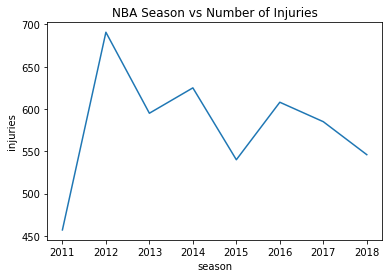

In [36]:
sns.lineplot(x = adj_seasonal_totals["season"], y = adj_seasonal_totals["injuries"])
plt.title("NBA Season vs Number of Injuries")
plt.show()

The eye test of this graph shows that, surprisingly, our data does not reveal a meaningful increase in injuries over time. However, when adjusted for the number of games played, the shortened 2012 season had the most injuries by far.

In [37]:
nonlockout_injuries = seasonal_totals[seasonal_totals["season"] != 2012]["injuries"].sum()
nonlockout_ipg = nonlockout_injuries / (82 * 7)
lockout_injuries = seasonal_totals["injuries"][1]
lockout_ipg = lockout_injuries/66
print("In full seasons, there were", round(nonlockout_ipg, 2), "injuries per game.")
print("In the 2012 lockout season, there were", round(lockout_ipg, 2), "injuries per game.")

In full seasons, there were 6.89 injuries per game.
In the 2012 lockout season, there were 8.42 injuries per game.


The lockout season saw a 22% increase in injuries per game.

## Injury Type by Season

I next wanted to look at whether specific injuries became more or less frequent over time. In particular, I was curious (based on my anecdotal memory of its past prevalence) whether Achilles injuries had increased in frequency. 

I create the full data frame with the 2012 season adjustment, dropping the columns that no longer make sense once summed. However, for analysis, I create a data frame with just the full seasons. There's statistical and conceptual reason to think that 2012 is anomalous, so I think dropping it is justified.  

In [0]:
seasons = just_injuries.groupby("season", as_index = False).sum()
seasons.iloc[1] = round(seasons.iloc[1] * lockout_factor, 2) 
seasons["season"][1] = 2012
seasons = seasons.drop(["month", "year", "days_since_start", "binned_days"], axis = 1)

full_seasons = seasons.drop(index = 1)

In [39]:
seasons.head(8)

,season,achilles,knee,concussion,ankle,back,hamstring,quadriceps,hip,wrist,neck,calf,foot,hand,thumb,elbow,shoulder,groin,finger,illness
0,2011.0,6.00,102.00,5.00,72.0,39.00,15.00,7.00,11.00,14.00,2.0,13.00,39.00,1.00,7.00,6.0,14.00,13.00,5.00,50.00
1,2012.0,14.91,119.27,16.15,123.0,60.88,24.85,6.21,18.64,11.18,0.0,17.39,38.52,4.97,4.97,8.7,33.55,37.27,6.21,62.12
2,2013.0,7.00,123.00,10.00,108.0,45.00,23.00,6.00,22.00,5.00,7.0,17.00,37.00,11.00,9.00,14.0,27.00,19.00,10.00,67.00
3,2014.0,9.00,143.00,2.00,110.0,53.00,31.00,4.00,14.00,15.00,4.0,21.00,38.00,14.00,5.00,7.0,19.00,13.00,5.00,65.00
4,2015.0,12.00,78.00,11.00,95.0,47.00,22.00,3.00,23.00,12.00,3.0,16.00,18.00,12.00,7.00,11.0,27.00,15.00,5.00,59.00
5,2016.0,12.00,115.00,14.00,82.0,53.00,24.00,4.00,26.00,10.00,2.0,16.00,32.00,6.00,9.00,4.0,37.00,12.00,7.00,61.00
6,2017.0,16.00,111.00,11.00,97.0,30.00,33.00,5.00,28.00,19.00,1.0,22.00,32.00,10.00,13.00,5.0,19.00,14.00,7.00,61.00
7,2018.0,11.00,112.00,14.00,104.0,33.00,16.00,5.00,20.00,17.00,5.0,12.00,23.00,12.00,8.00,8.0,24.00,11.00,3.00,41.00


In [40]:
full_seasons.corr()

,season,achilles,knee,concussion,ankle,back,hamstring,quadriceps,hip,wrist,neck,calf,foot,hand,thumb,elbow,shoulder,groin,finger,illness
season,1.000000,0.820128,-0.041946,0.699642,0.342958,-0.332759,0.248286,-0.521383,0.679871,0.461120,-0.119291,0.105964,-0.620323,0.486526,0.450878,-0.257293,0.386279,-0.427760,-0.278315,-0.266900
achilles,0.820128,1.000000,-0.227393,0.535044,0.110775,-0.317536,0.544149,-0.565991,0.795945,0.519005,-0.526355,0.443948,-0.512905,0.314314,0.648825,-0.395507,0.250767,-0.273028,-0.087466,0.042024
knee,-0.041946,-0.227393,1.000000,-0.413402,0.479687,0.256254,0.439623,0.156579,-0.227020,-0.030669,0.341856,0.429286,0.681888,0.273493,-0.134930,-0.133574,-0.089953,-0.019372,0.222301,0.339152
concussion,0.699642,0.535044,-0.413402,1.000000,-0.046828,-0.280081,-0.205133,-0.231860,0.779151,-0.091689,0.005107,-0.326063,-0.625576,0.043788,0.560887,0.016463,0.689291,-0.091161,0.082744,-0.278724
ankle,0.342958,0.110775,0.479687,-0.046828,1.000000,0.029112,0.431762,-0.305991,0.153232,-0.026587,0.665501,0.417820,-0.126385,0.937489,-0.061290,0.523918,0.024516,0.330465,0.117142,0.287644
back,-0.332759,-0.317536,0.256254,-0.280081,0.029112,1.000000,0.156042,-0.461167,-0.151679,-0.590816,0.161741,0.130167,0.171114,0.103434,-0.601720,0.107289,0.491907,0.124335,0.203140,0.565875
hamstring,0.248286,0.544149,0.439623,-0.205133,0.431762,0.156042,1.000000,-0.411057,0.418673,0.197088,-0.240051,0.984512,0.218017,0.470090,0.344696,-0.198160,0.001401,0.173005,0.361538,0.728513
quadriceps,-0.521383,-0.565991,0.156579,-0.231860,-0.305991,-0.461167,-0.411057,1.000000,-0.430963,-0.075801,0.145347,-0.308532,0.624383,-0.598340,0.162994,0.030066,-0.514965,0.183136,0.221637,-0.261381
hip,0.679871,0.795945,-0.227020,0.779151,0.153232,-0.151679,0.418673,-0.430963,1.000000,-0.061241,-0.166154,0.320264,-0.433668,0.262166,0.767515,-0.018601,0.626701,0.171803,0.411361,0.278604
wrist,0.461120,0.519005,-0.030669,-0.091689,-0.026587,-0.590816,0.197088,-0.075801,-0.061241,1.000000,-0.559039,0.175007,-0.188779,0.076472,0.181674,-0.614888,-0.551825,-0.681859,-0.686292,-0.490774


The main thing I want to look at in this table is how various injury rates correlate with the season. Achilles injuries seem to have a very strong positive correlation. Similarly, concussions have increased by season -- this would make sense given the increased focus in recent years on diagnosing and appropriately treating head injuries.

This code takes a data frame and returns a matrix with pairwise p-values. I use this to investigate the relationship between season progression and injury rates for specific injuries.

In [0]:
df_p_values = pd.DataFrame()
for x in full_seasons.columns:
    for y in full_seasons.columns:
        corr = pearsonr(full_seasons[x], full_seasons[y])
        df_p_values.loc[x,y] = corr[1]

In [42]:
df_p_values["season"]

season        2.494476e-40
achilles      2.386041e-02
knee          9.288536e-01
concussion    8.013811e-02
ankle         4.514036e-01
back          4.658395e-01
hamstring     5.913668e-01
quadriceps    2.301010e-01
hip           9.287777e-02
wrist         2.976786e-01
neck          7.989226e-01
calf          8.211180e-01
foot          1.372202e-01
hand          2.682266e-01
thumb         3.099347e-01
elbow         5.775196e-01
shoulder      3.920414e-01
groin         3.383845e-01
finger        5.456028e-01
illness       5.628612e-01
Name: season, dtype: float64

Most injury rates haven't statistically significantly changed over time (perhaps as expected given our relatively small sample).

In [43]:
pearsonr(full_seasons["season"], full_seasons["achilles"])

(0.8201279470319384, 0.023860405796626415)

With p=.02, we can naively reject the null hypothesis that Achilles injuries are constant over time and conclude that they're related to the progression of seasons.

However, there are a lot of researcher degrees of freedom in this analysis. Specifically, my choice of Achilles injuries to investigate (one of many possible comparisons) was nonrandom. In a world where true injury rates are constant, we'd still expect to see some random trends pop up and get picked up on by watchers of the game and ESPN.

But teams don't get the luxury of waiting for more data to come in; they have to operate on limited information while trying to minimize injury. Given that, I'd consider the increase in Achilles injuries to be good evidence that teams and trainers should pay attention to Achilles wear and tear.

##Injuries Within Seasons

Next I want to examine how the cumulative wear of an NBA season affects injury rate. I create a count of rows, each of which represents a number of injuries that happened in one season-bin. I then separate the lockout season, which would be expected to show a different pattern.

In [0]:
season_progressions = just_injuries.groupby(by = ["season", "binned_days"]).count()

In [0]:
season_progressions = season_progressions.reset_index()
season_progressions = season_progressions[["season", "binned_days", "date"]]
season_progressions.columns = ["season", "binned_days", "n_injuries"]

In [0]:
lockout_progression = season_progressions[season_progressions["season"] == 2012]

In [0]:
def bin_seasons(season):
  if season in [2011, 2013, 2014, 2015, 2016, 2017, 2018]:
    return True
  else: 
    return False

non_lockouts = season_progressions[season_progressions["season"].apply(bin_seasons)]

In [48]:
non_lockouts.head()

,season,binned_days,n_injuries
0,2011.0,0,19
1,2011.0,1,20
2,2011.0,2,24
3,2011.0,3,29
4,2011.0,4,35


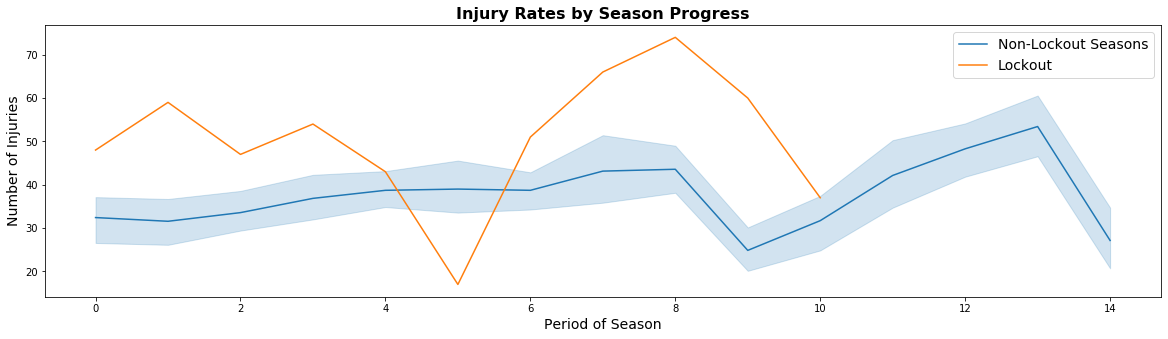

In [49]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.lineplot(x = "binned_days", y = "n_injuries", data = non_lockouts)
sns.lineplot(x = "binned_days", y = "n_injuries", data = lockout_progression)

ax.set_xlabel("Period of Season", fontsize = 14)
ax.set_ylabel("Number of Injuries", fontsize = 14)
ax.set_title("Injury Rates by Season Progress", fontsize = 16, fontweight = "bold")
plt.legend(labels=['Non-Lockout Seasons', 'Lockout'], fontsize = 14)

plt.show()

We can see from the confidence intervals surrounding the bins that there's a meaningful increase in injuries between the beginning of the season and immediately pre-All-Star-Break. We then observe a decrease due to the break, which seems to temporarily reset injury rates. 

However, it only takes a few weeks for injury rates to go back up to their pre-ASB levels, which they then exceed. (The last bin is distorted by teams playing unusual rotations once they've clinched playoff seeding.)

##In-Season Rest

First I look at total days of rest by season, adjusting the 2012 season for the lockout.

In [50]:
rest_totals = pd.DataFrame(rest["season"].value_counts())
rest_totals = rest_totals.reset_index()
rest_totals.columns = ["season", "days of rest"]

rest_totals = rest_totals.sort_values(by = "season")
rest_totals = rest_totals.reset_index(drop = True)
rest_totals.iloc[1, 1] = round((rest_totals.iloc[1,1] * 82/66), 2)
rest_totals

,season,days of rest
0,2011.0,33.00
1,2012.0,89.45
2,2013.0,31.00
3,2014.0,61.00
4,2015.0,65.00
5,2016.0,108.00
6,2017.0,130.00
7,2018.0,42.00


In [51]:
pearsonr(rest_totals.drop(index = 1)["season"], rest_totals.drop(index = 1)["days of rest"])

(0.5538042356185349, 0.1971072030018494)

Though this relationship isn't statistically significant, the two highest totals of rest days are in the last few years. Organizations have talked at length about resting players and managing fatigue, so I'd expect these numbers to trend upward in the future.

In [0]:
merged_seasons = seasonal_totals.merge(rest_totals, on = "season")

A scatter plot doesn't show much relationship between days of rest and injuries, at least on a seasonal level.

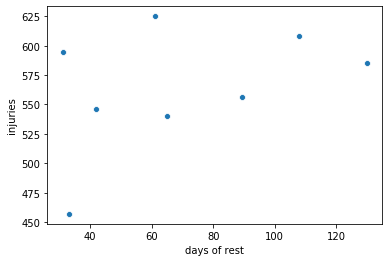

In [53]:
sns.scatterplot(x = merged_seasons["days of rest"], y = merged_seasons["injuries"])
plt.show()

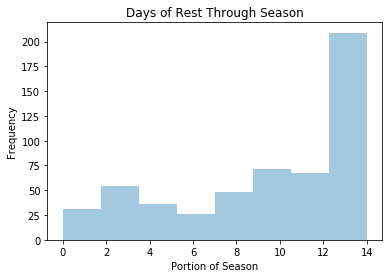

In [54]:
fig, ax = plt.subplots()
sns.distplot(rest["binned_days"], kde = False)

ax.set_xlabel("Portion of Season")
ax.set_ylabel("Frequency")
ax.set_title("Days of Rest Through Season")
plt.show()

We can see that the frequency of rest goes up dramatically in the second half of the season, peaking at the absolute end as teams either get ready for the playoffs or fall out of playoff contention.

##Team Data

In [0]:
# Generate team-level rest data
rest_teams = pd.DataFrame(rest["team"].value_counts()).reset_index()
rest_teams.columns = ["team", "days of rest"]

In [56]:
rest_teams.head()

,team,days of rest
0,Spurs,84
1,Kings,37
2,Mavericks,32
3,Hawks,31
4,Cavaliers,29


In [57]:
rest_teams.tail()

,team,days of rest
25,Pistons,7
26,Magic,7
27,Timberwolves,3
28,Hornets,1
29,Jazz,1


The San Antonio Spurs have by far the most days of rest in the data set. This matches their reputation as pioneers of player rest and of getting the most out of their aging players.

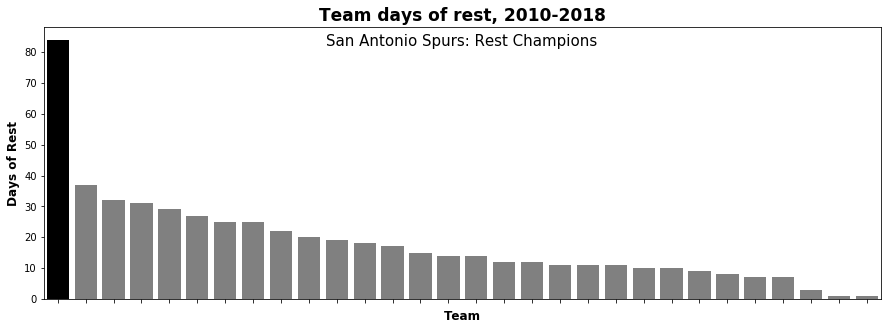

In [58]:
fig, ax = plt.subplots(figsize = (15, 5))

colors = ["black" if team == "Spurs" else "grey" for team in rest_teams["team"]]
sns.barplot(x = rest_teams["team"], y = rest_teams["days of rest"], palette = colors)

ax.set_xticklabels("")
ax.set_xlabel("Team", fontweight = "bold", fontsize = 12)
ax.set_ylabel("Days of Rest", fontweight = "bold", fontsize = 12)
ax.text(s = "San Antonio Spurs: Rest Champions", x = 9.6, y = 82, fontsize = 15)
ax.set_title("Team days of rest, 2010-2018", fontweight="bold", fontsize = 17)

plt.show()

In [59]:
rest["player"].value_counts().head(10)

Emanuel Ginobili / Manu Ginobili    20
Tim Duncan                          19
Kevin Garnett                       17
Rajon Rondo                         16
(William) Tony Parker               16
LeBron James                        15
Chandler Parsons                    12
Joel Embiid                         12
Eric Gordon                         10
Paul Pierce                          9
Name: player, dtype: int64

As you might expect, the leaderboard for individuals is dominated by Spurs, with the Spurs' "big three" -- Manu Ginobili, Tim Duncan, and Tony Parker -- all in the top five. Teams competing for a title, as with the Spurs and the Celtics (Kevin Garnett, Rajon Rondo, and Paul Pierce) may consider the regular season less important than the playoffs, although, as the Spurs have shown, rest doesn't necessarily come at the expense of regular-season success.

##Teams and Injuries

In [0]:
injury_teams = pd.DataFrame(just_injuries["team"].value_counts()).reset_index()
injury_teams.columns = ["team", "injuries"]
# I drop the one player who snuck in without an associated team
injury_teams = injury_teams.drop(index = 30)

In [61]:
injury_teams.head()

150.36666666666667


,team,injuries
0,76ers,205
1,Bucks,204
2,Nuggets,189
3,Rockets,186
4,Pelicans,181


In [62]:
injury_teams.tail()

,team,injuries
25,Blazers,109
26,Mavericks,109
27,Pistons,107
28,Pacers,102
29,Thunder,66


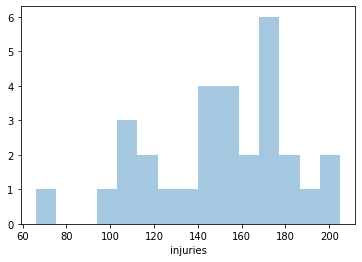

In [63]:
sns.distplot(injury_teams["injuries"], kde = False, bins = 15)
plt.show()

In [64]:
normaltest(injury_teams["injuries"])

NormaltestResult(statistic=1.8034784991591795, pvalue=0.4058631482088628)

We can't reject the null hypothesis that injuries are normally distributed. Though, with 30 teams, we'd expect to see 1.5 teams that registered as p<.05 significant by chance, let's check the relationship between the Thunder (at 66 injuries) and the rest of the league (at an average of (check) 150 injuries. 

In [65]:
std = np.std(injury_teams["injuries"], ddof = 1)
mean = np.mean(injury_teams["injuries"])
thunder = injury_teams[injury_teams["team"] == "Thunder"].iloc[0][1]
deviations = (mean - thunder)/std
deviations

2.598285641011523

The Thunder are 2.60 standard deviations from the mean, which is significant at the 1% level. However, given the likelihood of 1% outliers across a large data set with multiple features, I would say this effect is more "something to look deeper into" than a definite feature of reality.

In [0]:
team_data = injury_teams.merge(rest_teams, on = "team")

In [67]:
np.corrcoef(team_data["injuries"], team_data["days of rest"])

array([[1.        , 0.00288544],
       [0.00288544, 1.        ]])

There's almost zero correlation between total days of rest and total injuries. However, this is likely an artifact both of underlying variables and of our data set -- oft-injured players are more likely to get rested, and teams might label intended rest days as minor injuries. The best evidence that there's a relationship between rest and injury rate comes from observation: NBA teams, with millions of dollars in labor productivity at stake, have almost universally adopted the Spurs' style of giving players occasional rest day to keep them in peak condition.

#Conclusions

Though the NBA is more concerned with injuries than ever before, this data set was unable to draw out a consistent increase in injury rates over the last eight seasons. However, data that included missed games might yield different conclusions. 

Achilles injuries might be a useful bellwether -- as the most load-bearing tendon in the body, it's most susceptible to overuse injuries, and there is little flexibility in how the injury is reported. We did see a significant increase in Achilles injuries over the time frame. 

Given increased injury rates in the low-rest lockout season, increased injury rates as a season progresses, and anecdotal evidence from the league's most successful team, what this data set most strongly suggests to me is the effectiveness of rest in injury prevention.